In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import scanpy as sc
import numpy as np
from scipy.spatial import KDTree
from anndata import AnnData
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import scanorama

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
datadir = "/Users/anna.schaar/phd/datasets/"

In [3]:
datadir = '/storage/groups/ml01/workspace/anna.schaar/ncem/data/'

# Loading the integrated whole transcriptome adata object

In [4]:
#wt_adata = sc.read_h5ad(datadir + "lu/mnn_corrected_fetal_liver.h5ad")
fetal_liver = sc.read(datadir + "lu/fetal_liver.h5ad")
#sorted_hsc = sc.read(datadir + "lu/sorted_HSC.h5ad")

In [5]:
fetal_liver.var_names

Index([         b'Sox17',         b'Mrpl15',         b'Lypla1',
              b'Gm37988',          b'Tcea1',        b'Atp6v1h',
               b'Rb1cc1',  b'4732440D04Rik',           b'St18',
               b'Pcmtd1',
       ...
               b'mt-Nd5',         b'mt-Nd6',        b'mt-Cytb',
                b'Vamp7',          b'Spry3',          b'Tmlhe',
           b'AC125149.3',           b'PISD',          b'DHRSX',
       b'CAAA01147332.1'],
      dtype='object', name='gene_short_name', length=16187)

In [6]:
#wt_adata.var_names = [x.decode('utf-8') for x in list(wt_adata.var_names)]
fetal_liver.var_names = [x.decode('utf-8') for x in list(fetal_liver.var_names)]
#sorted_hsc.var_names = [x.decode('utf-8') for x in list(sorted_hsc.var_names)]

# Loading the merfish dataset from ncem

In [7]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + 'lu/',
    data_origin='luwt',
    radius=200,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

merfish_adata = interpreter.data.celldata

Loading data from raw files
registering celldata
['AEC', 'Erythroid cell', 'Erythroid progenitor', 'Hepatocyte', 'MK', 'Macrophage', 'Myeloid', 'SEC', 'Unknown']
collecting image-wise celldata


 28%|██▊       | 39/140 [00:00<00:00, 387.14it/s]

adding graph-level covariates


100%|██████████| 140/140 [00:00<00:00, 374.53it/s]

Loaded 140 images with complete data from 1 patients over 40864 cells with 132 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 16.576537

 Celldata metadata: {'lateral_resolution': 0.1079, 'fn': 'FinalClusteringResults 190517 WT.csv', 'image_col': 'FOV', 'pos_cols': ['Center_x', 'Center_y'], 'cluster_col': 'CellTypeID_new', 'cluster_col_preprocessed': 'CellTypeID_new_preprocessed', 'scRNAseq_fn': ['fetal_liver.h5ad', 'sorted_HSC.h5ad']}


## Normalizing and log transforming merfish

In [8]:
merfish_adata = merfish_adata[merfish_adata.obs['CellTypeID_new_preprocessed'] != 'Unknown']

sc.pp.normalize_total(merfish_adata, target_sum=1e5)
sc.pp.log1p(merfish_adata)

sc.pp.highly_variable_genes(merfish_adata, n_top_genes=20)
hvg_merfish = [x for i, x in enumerate(merfish_adata.var_names) if list(merfish_adata.var['highly_variable'])[i]]

In [10]:
merfish_raw = merfish_adata.copy()

## Get the intersection of merfish and whole transcriptome markers for mnn data integration

In [9]:
fetal_liver_integration_markers = list(set.intersection(set(merfish_adata.var_names), set(fetal_liver.var_names)))

adatas = [fetal_liver[:,fetal_liver_integration_markers], merfish_adata[:,fetal_liver_integration_markers]]

mnn_corrected = sc.external.pp.mnn_correct(
    *adatas, do_concatenate=False, k=25
)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [ ]:
mnn_corrected

In [10]:
integrated_merfish = mnn_corrected[0][1]

tree = KDTree(mnn_corrected[0][0].X.toarray())
dd, ii = tree.query(integrated_merfish.X, k=25)

imputed_wt = []
for i in range(integrated_merfish.shape[0]):
    imputed_wt.append(np.mean(fetal_liver[ii[i]].X, axis=0)[np.newaxis, :])
imputed_wt = np.concatenate(imputed_wt)

merfish_wt = AnnData(
    X=pd.DataFrame(imputed_wt, columns=fetal_liver.var_names), 
    obs=integrated_merfish.obs
)

control_markers = list(set.intersection(set(fetal_liver_integration_markers), set(hvg_merfish)))

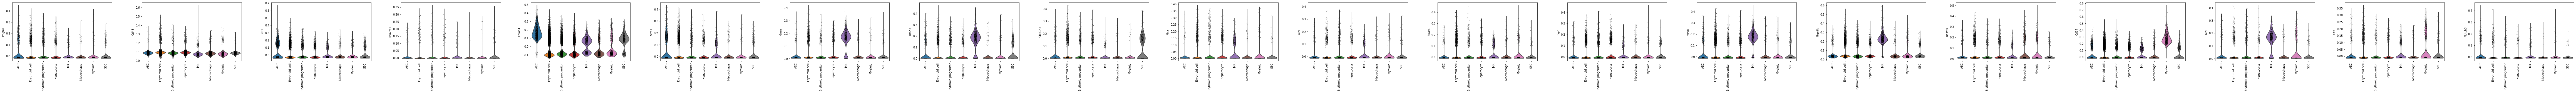

In [14]:
sc.pl.violin(merfish_adata, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

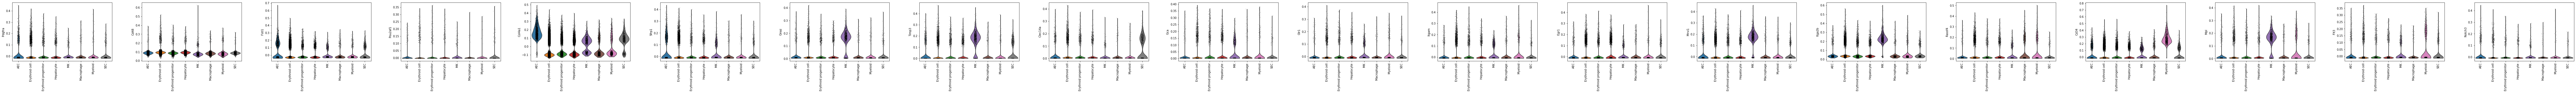

In [15]:
sc.pl.violin(integrated_merfish, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

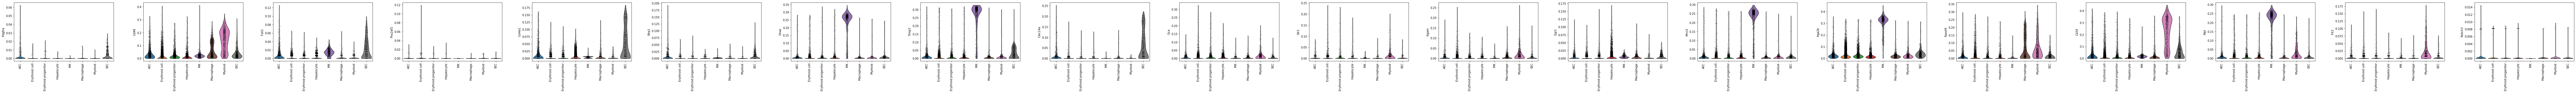

In [16]:
sc.pl.violin(merfish_wt, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

In [10]:
integrated_merfish = mnn_corrected[0][1]
tree = KDTree(wt_adata[:,integration_markers].X)
dd, ii = tree.query(integrated_merfish.X, k=25)

imputed_wt = []
for i in range(integrated_merfish.shape[0]):
    imputed_wt.append(np.mean(wt_adata[ii[i]].X, axis=0)[np.newaxis, :])
imputed_wt = np.concatenate(imputed_wt)

merfish_wt = AnnData(
    X=pd.DataFrame(imputed_wt, columns=wt_adata.var_names), 
    obs=integrated_merfish.obs
)
control_markers = list(set.intersection(set(integration_markers), set(hvg_merfish)))

In [13]:
sc.pl.violin(integrated_merfish, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

Trying to set attribute `.uns` of view, copying.


KeyboardInterrupt: 

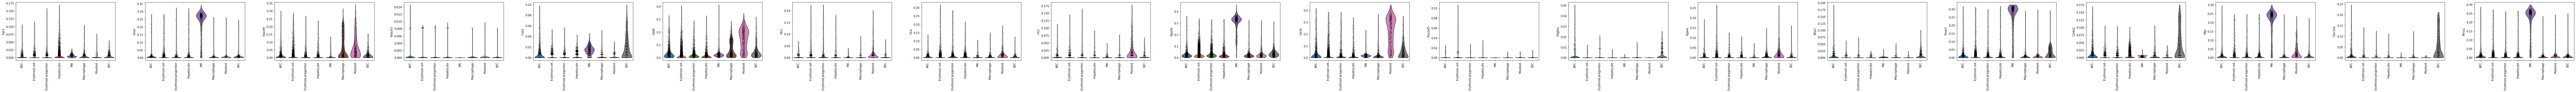

In [16]:
sc.pl.violin(merfish_wt, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

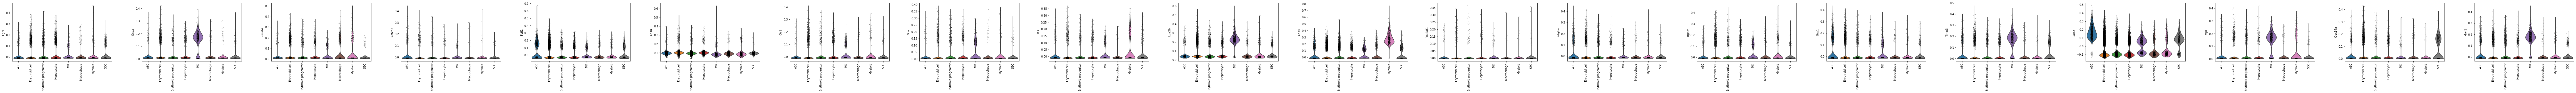

In [17]:
sc.pl.violin(merfish_adata, control_markers, groupby='CellTypeID_new_preprocessed', rotation=90)

## Sanity checks

In [18]:
control_markers

['Egr1',
 'Gnaz',
 'Rassf4',
 'Notch3',
 'Fstl1',
 'Cd48',
 'Olr1',
 'Gca',
 'Flt3',
 'Itga2b',
 'Cd34',
 'Pou2af1',
 'Pdgfra',
 'Itgam',
 'Sfrp1',
 'Timp3',
 'Col4a1',
 'Mpl',
 'Clec14a',
 'Mrvi1']

Egr1


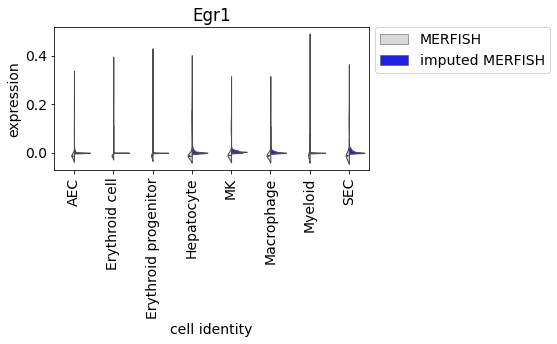

Gnaz


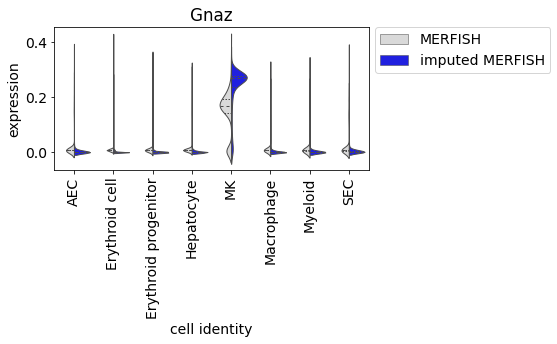

Rassf4


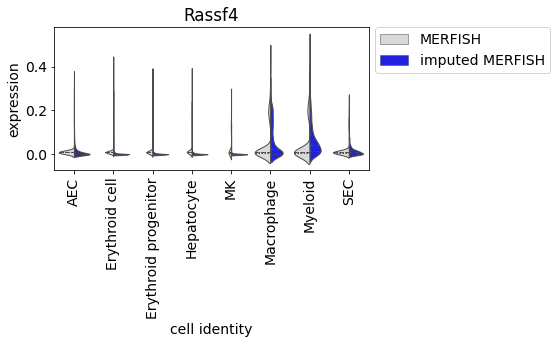

Notch3


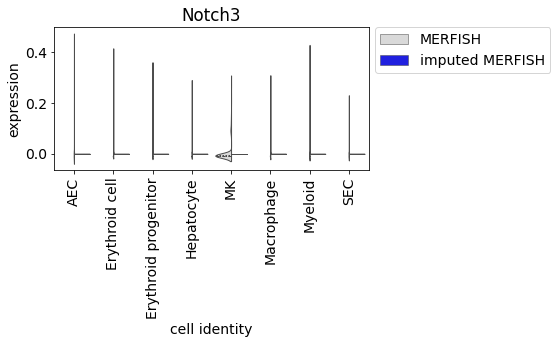

Fstl1


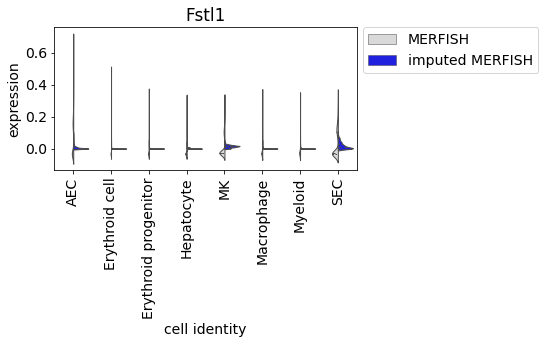

Cd48


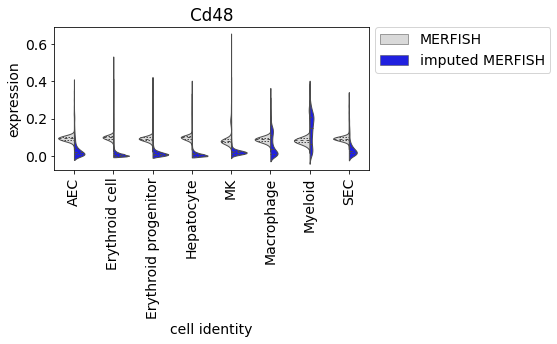

Olr1


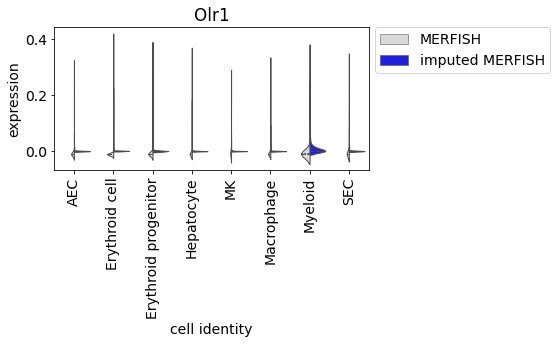

Gca


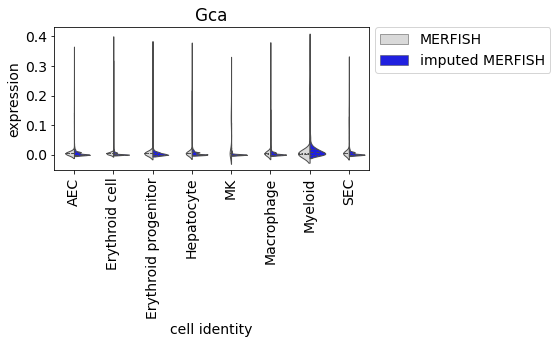

Flt3


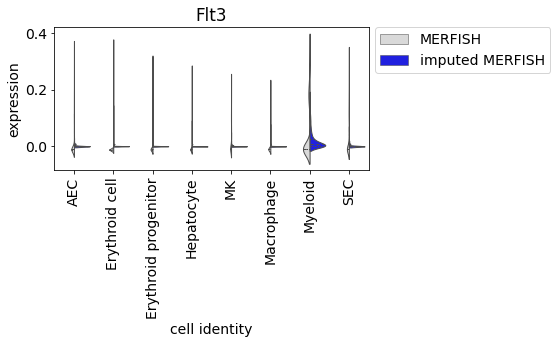

Itga2b


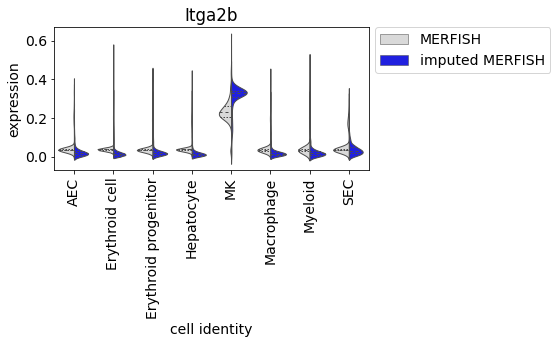

Cd34


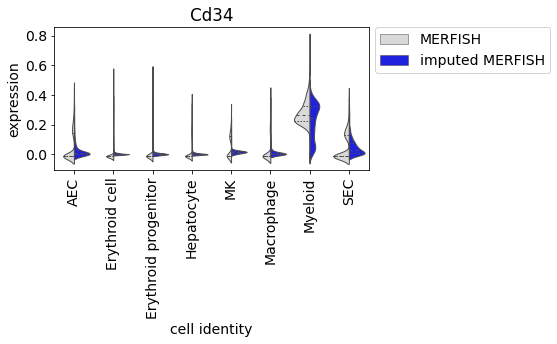

Pou2af1


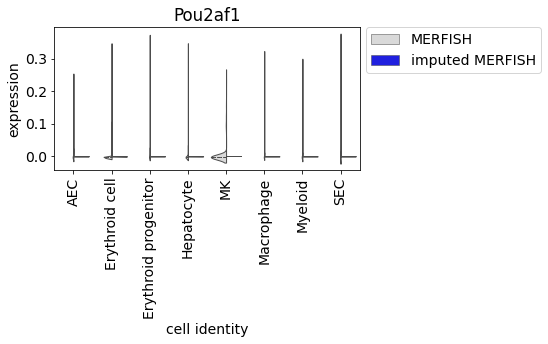

Pdgfra


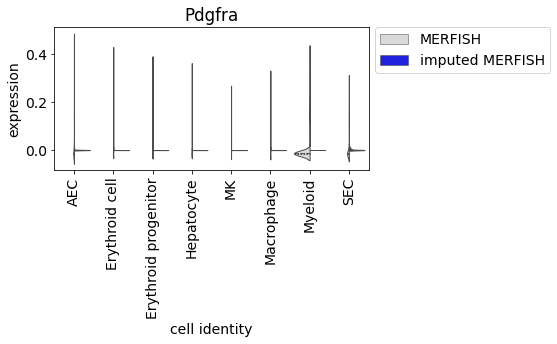

Itgam


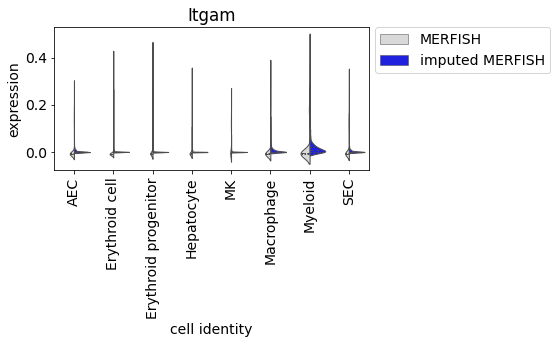

Sfrp1


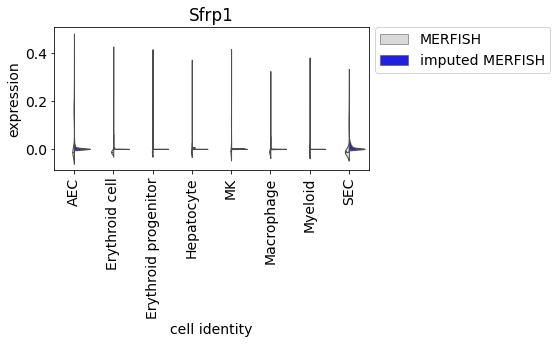

Timp3


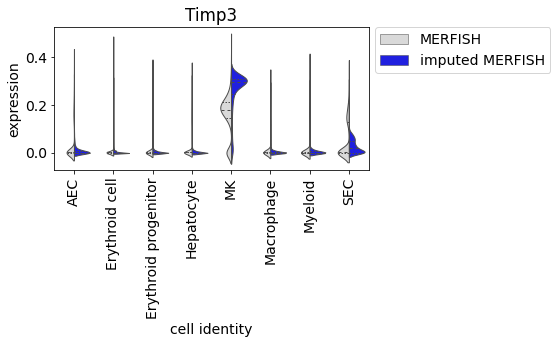

Col4a1


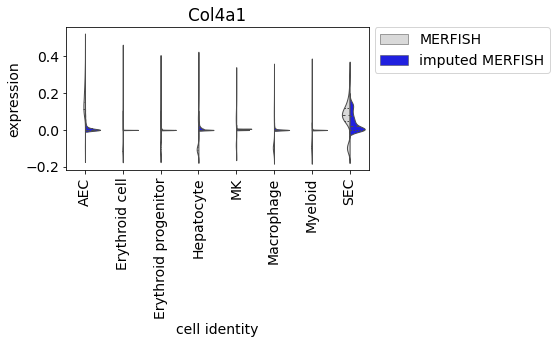

Mpl


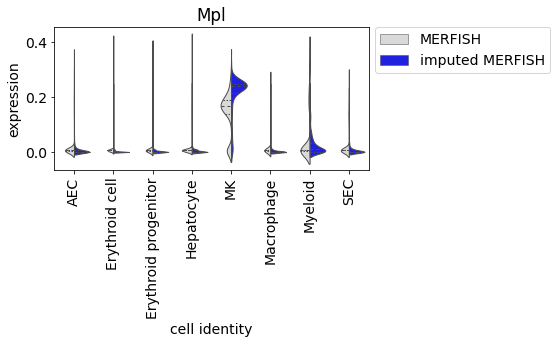

Clec14a


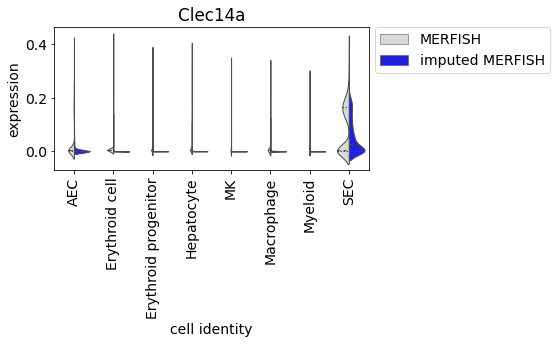

Mrvi1


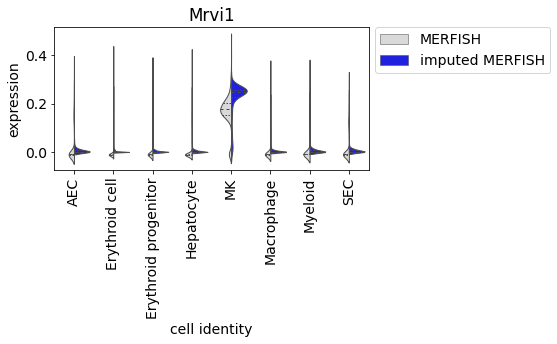

In [19]:
for marker in control_markers:
    print(marker)
    integrated_merfish_check = pd.DataFrame(integrated_merfish[:, [marker]].X, columns=[marker])


    integrated_merfish_check = pd.DataFrame(
        integrated_merfish_check.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    integrated_merfish_check['cell identity'] = list(integrated_merfish.obs['CellTypeID_new_preprocessed'])

    merfish_wt_check = pd.DataFrame(merfish_wt[:, [marker]].X, columns=[marker])

    merfish_wt_check = pd.DataFrame(
        merfish_wt_check.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    merfish_wt_check['cell identity'] = list(merfish_wt.obs['CellTypeID_new_preprocessed'])

    integrated_merfish_check['sample'] = 'MERFISH'
    merfish_wt_check['sample'] = 'imputed MERFISH'

    sanity_check = pd.concat([integrated_merfish_check, merfish_wt_check])
    sanity_check = sanity_check[sanity_check['cell identity'] != 'Unknown']

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    sns.violinplot(
        data=sanity_check.sort_values(by=['cell identity']), x='cell identity', 
        y='expression', inner="quart", hue="sample", 
        split=True, 
        linewidth=1, ax=ax,
        palette={"imputed MERFISH": "b", "MERFISH": ".85"}
    )
    ax.set_title(marker)
    ax.grid(False)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()